In [ ]:
# 전체 병합

# CBCT와 MRI 피클 파일 로드
import pickle
import numpy as np

with open('/content/drive/MyDrive/TMJ OA/학습_data_1,3(crop)/tmj_oa_CBCT1,3_dataset_3.pkl', 'rb') as f:
    cbct_data = pickle.load(f)

with open('/content/drive/MyDrive/TMJ OA/학습_data_MRI_1,2/tmj_oa_MRI1,2_dataset_2.pkl', 'rb') as f:
    mri_data = pickle.load(f)

# 공통 환자 ID 추출
cbct_patient_ids = set(cbct_data['train_data']['patient_id'])
mri_patient_ids = set(mri_data['train_data']['patient_id'])
common_patient_ids = cbct_patient_ids.intersection(mri_patient_ids)
print(f"공통 환자 수: {len(common_patient_ids)}")

# 공통 환자의 데이터를 필터링하는 함수
def filter_common_data(data, common_ids, stage):
    filtered_data = {'image': [], 'label': [], 'patient_id': [], 'side': []}
    for i, pid in enumerate(data[stage]['patient_id']):
        if pid in common_ids:
            filtered_data['image'].append(data[stage]['image'][i])
            filtered_data['label'].append(data[stage]['label'][i])
            filtered_data['patient_id'].append(pid)
            filtered_data['side'].append(data[stage]['side'][i])
    return filtered_data

# Train, Validation, Test 데이터 필터링 및 병합
combined_data = {}
for stage in ['train_data', 'validation_data', 'test_data']:
    filtered_cbct = filter_common_data(cbct_data, common_patient_ids, stage)
    filtered_mri = filter_common_data(mri_data, common_patient_ids, stage)

    combined_data[stage] = {
        'CBCT_image': np.array(filtered_cbct['image']),
        'MRI_image': np.array(filtered_mri['image']),
        'label': np.array(filtered_cbct['label']),
        'patient_id': np.array(filtered_cbct['patient_id']),
        'side': np.array(filtered_cbct['side'])
    }

# 병합된 데이터 저장
with open('/content/drive/MyDrive/TMJ OA/CBCT_MRI_combined_full.pkl', 'wb') as f:
    pickle.dump(combined_data, f)

print("CBCT와 MRI 데이터 병합 완료. Train/Validation/Test 포함된 데이터 저장됨: CBCT_MRI_combined_full.pkl")

공통 환자 수: 138
CBCT와 MRI 데이터 병합 완료. Train/Validation/Test 포함된 데이터 저장됨: CBCT_MRI_combined_full.pkl


Train Data: CBCT=(194, 140, 140, 3), MRI=(194, 140, 140, 3), Labels=(194,)
Validation Data: CBCT=(44, 140, 140, 3), MRI=(44, 140, 140, 3), Labels=(44,)
Test Data: CBCT=(37, 140, 140, 3), MRI=(37, 140, 140, 3), Labels=(37,)
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step

Train 데이터 평가:
Ensemble Model AUC: 0.9326
Optimal Threshold: 0.2676

Confusion Matrix:
[[111  17]
 [  8  58]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       128
           1       0.77      0.88      0.82        66

    accuracy                           0.87       194
   macro avg       0.85      0.87      0.86       194
weighted avg       0.88      0.87      0.87       194

Accuracy: 0.8711


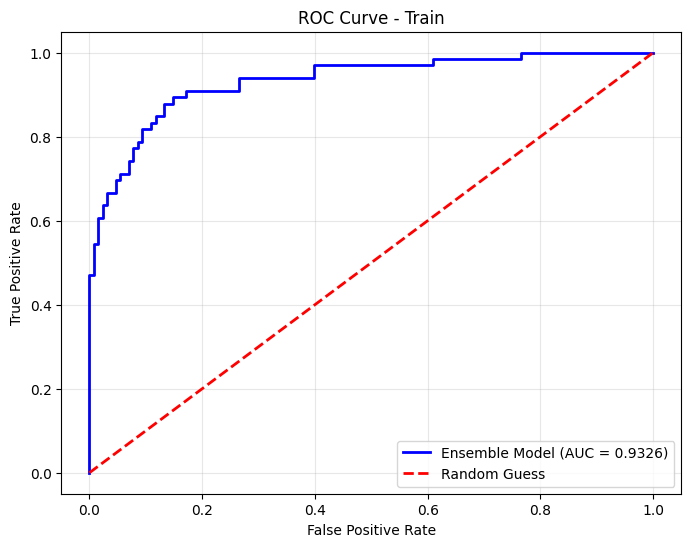

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step

Validation 데이터 평가:
Ensemble Model AUC: 0.7469
Optimal Threshold: 0.4534

Confusion Matrix:
[[31  0]
 [ 5  8]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.93        31
           1       1.00      0.62      0.76        13

    accuracy                           0.89        44
   macro avg       0.93      0.81      0.84        44
weighted avg       0.90      0.89      0.88        44

Accuracy: 0.8864


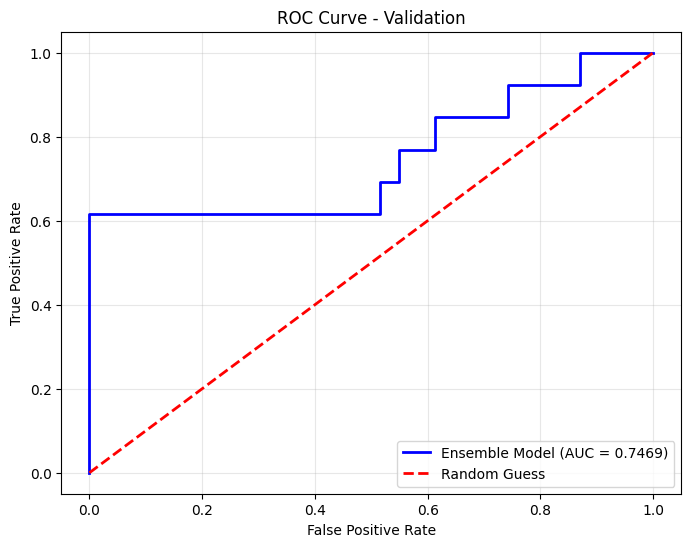

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step

Test 데이터 평가:
Ensemble Model AUC: 0.8133
Optimal Threshold: 0.4767

Confusion Matrix:
[[21  4]
 [ 4  8]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        25
           1       0.67      0.67      0.67        12

    accuracy                           0.78        37
   macro avg       0.75      0.75      0.75        37
weighted avg       0.78      0.78      0.78        37

Accuracy: 0.7838


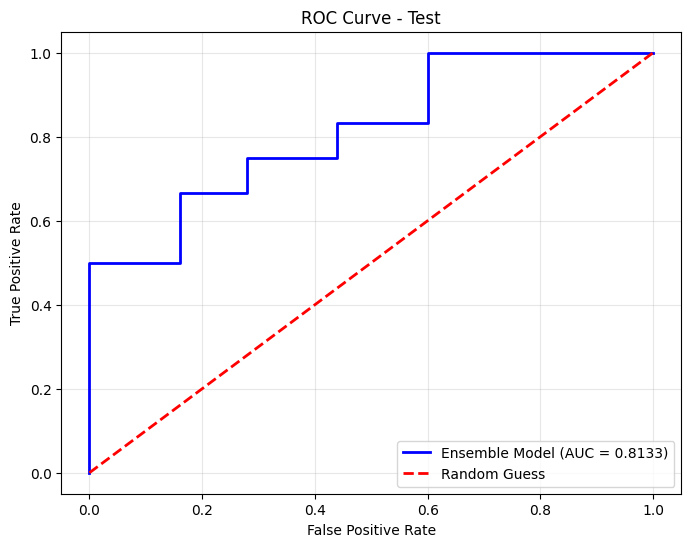

In [2]:
import pickle
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# 1. 병합된 데이터 로드
with open('/content/drive/MyDrive/TMJ OA/CBCT_MRI_combined_full.pkl', 'rb') as f:
    combined_data = pickle.load(f)

# 데이터 준비 함수: CBCT와 MRI 데이터를 공통 환자에 대해서만 가져옴
def prepare_common_data(stage, combined_data):
    cbct_images = combined_data[stage]['CBCT_image']
    mri_images = combined_data[stage]['MRI_image']
    labels = combined_data[stage]['label']

    # 데이터 일관성을 맞추기 위해 공통 길이로 맞춤
    min_samples = min(len(cbct_images), len(mri_images), len(labels))
    return cbct_images[:min_samples] / 255.0, mri_images[:min_samples] / 255.0, labels[:min_samples]

# Train, Validation, Test 데이터 준비
cbct_train, mri_train, train_labels = prepare_common_data('train_data', combined_data)
cbct_val, mri_val, val_labels = prepare_common_data('validation_data', combined_data)
cbct_test, mri_test, test_labels = prepare_common_data('test_data', combined_data)

print(f"Train Data: CBCT={cbct_train.shape}, MRI={mri_train.shape}, Labels={train_labels.shape}")
print(f"Validation Data: CBCT={cbct_val.shape}, MRI={mri_val.shape}, Labels={val_labels.shape}")
print(f"Test Data: CBCT={cbct_test.shape}, MRI={mri_test.shape}, Labels={test_labels.shape}")

# 2. 기존 모델 불러오기
cbct_model = load_model('/content/drive/MyDrive/TMJ OA/학습_data_1,3(crop)/CBCT1,3_model.keras')
mri_model = load_model('/content/drive/MyDrive/TMJ OA/학습_data_MRI_1,2/MRI1,2_model.keras')

# 3. 예측 및 평가 함수
def evaluate_ensemble(cbct_model, mri_model, cbct_images, mri_images, labels, stage):
    # 모델 예측
    cbct_preds = cbct_model.predict(cbct_images).flatten()
    mri_preds = mri_model.predict(mri_images).flatten()
    #ensemble_preds = (cbct_preds + mri_preds) / 2.0  # 앙상블 예측값
    #앙상블 가중치 최적화
    weight_cbct = 0.6  # CBCT 모델 가중치
    weight_mri = 0.4   # MRI 모델 가중치
    ensemble_preds = (weight_cbct * cbct_preds + weight_mri * mri_preds)


    # ROC Curve 및 AUC 계산
    fpr, tpr, thresholds = roc_curve(labels, ensemble_preds)
    ensemble_auc = auc(fpr, tpr)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    # 최종 예측
    final_preds = (ensemble_preds >= optimal_threshold).astype(int)

    # 성능 평가
    accuracy = accuracy_score(labels, final_preds)
    conf_matrix = confusion_matrix(labels, final_preds)
    class_report = classification_report(labels, final_preds)

    # 결과 출력
    print(f"\n{stage} 데이터 평가:")
    print(f"Ensemble Model AUC: {ensemble_auc:.4f}")
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)
    print(f"Accuracy: {accuracy:.4f}")

    # ROC Curve 시각화
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f"Ensemble Model (AUC = {ensemble_auc:.4f})")
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label="Random Guess")
    plt.title(f"ROC Curve - {stage}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

# 4. Train, Validation, Test 데이터 평가
evaluate_ensemble(cbct_model, mri_model, cbct_train, mri_train, train_labels, "Train")
evaluate_ensemble(cbct_model, mri_model, cbct_val, mri_val, val_labels, "Validation")
evaluate_ensemble(cbct_model, mri_model, cbct_test, mri_test, test_labels, "Test")


Train Data Shape: (194, 140, 140, 6), Labels: (194,)
Validation Data Shape: (44, 140, 140, 6), Labels: (44,)
Test Data Shape: (37, 140, 140, 6), Labels: (37,)


Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 140, 140, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 140, 140, 64)        │           3,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 140, 140, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 70, 70, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 70, 70, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 70, 70, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 35, 35, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 35, 35, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 35, 35, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 35, 35, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 17, 17, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 17, 17, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 17, 17, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 17, 17, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 16,814,081 (64.14 MB)

 Trainable params: 16,814,081 (64.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.5243 - loss: 1.1721 - val_accuracy: 0.7045 - val_loss: 6.7570
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - accuracy: 0.6873 - loss: 2.9260 - val_accuracy: 0.7045 - val_loss: 0.6876
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step - accuracy: 0.6409 - loss: 0.6889 - val_accuracy: 0.7045 - val_loss: 0.6834
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - accuracy: 0.6658 - loss: 0.6828 - val_accuracy: 0.7045 - val_loss: 0.6563
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 203ms/step - accuracy: 0.6312 - loss: 0.6614 - val_accuracy: 0.7045 - val_loss: 0.6219
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - accuracy: 0.6705 - loss: 0.6630 - val_accuracy: 0.7045 - val_loss: 0.6198
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - accuracy: 0.6459 - loss: 0.6517 - val_accuracy: 0.7045 - val_loss: 0.6201
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step - accuracy: 0.6385 - loss: 0.6547 - val_accuracy: 0.7045 - val_loss: 0

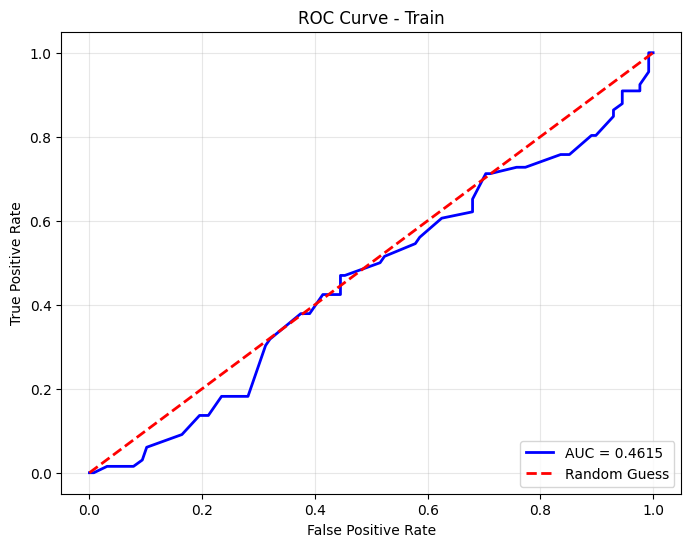

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step

Validation 데이터 평가:
AUC: 0.3871
Optimal Threshold: 0.2853
Confusion Matrix:
[[ 2 29]
 [ 0 13]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.06      0.12        31
           1       0.31      1.00      0.47        13

    accuracy                           0.34        44
   macro avg       0.65      0.53      0.30        44
weighted avg       0.80      0.34      0.23        44



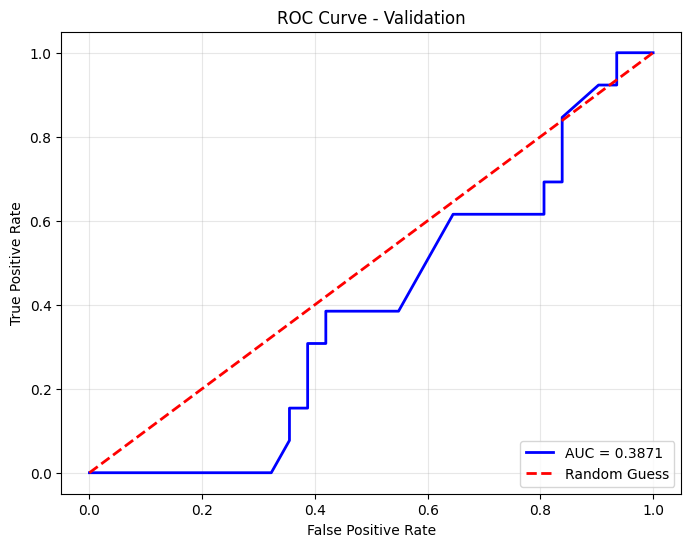

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step

Test 데이터 평가:
AUC: 0.5700
Optimal Threshold: 0.2853
Confusion Matrix:
[[13 12]
 [ 4  8]]
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.52      0.62        25
           1       0.40      0.67      0.50        12

    accuracy                           0.57        37
   macro avg       0.58      0.59      0.56        37
weighted avg       0.65      0.57      0.58        37



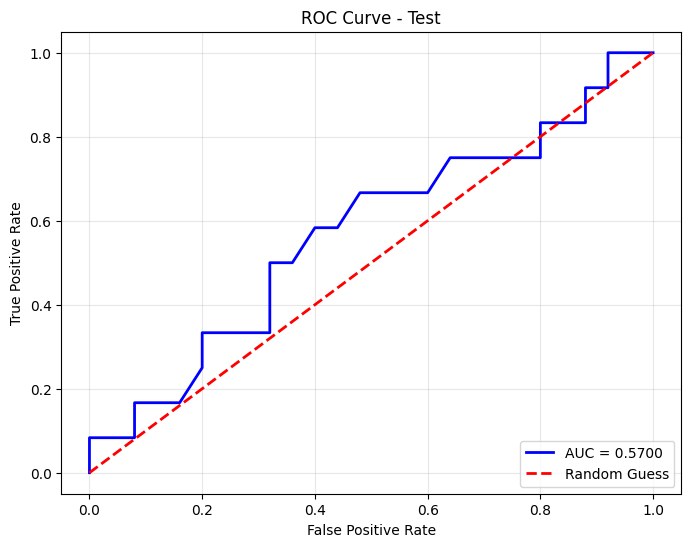

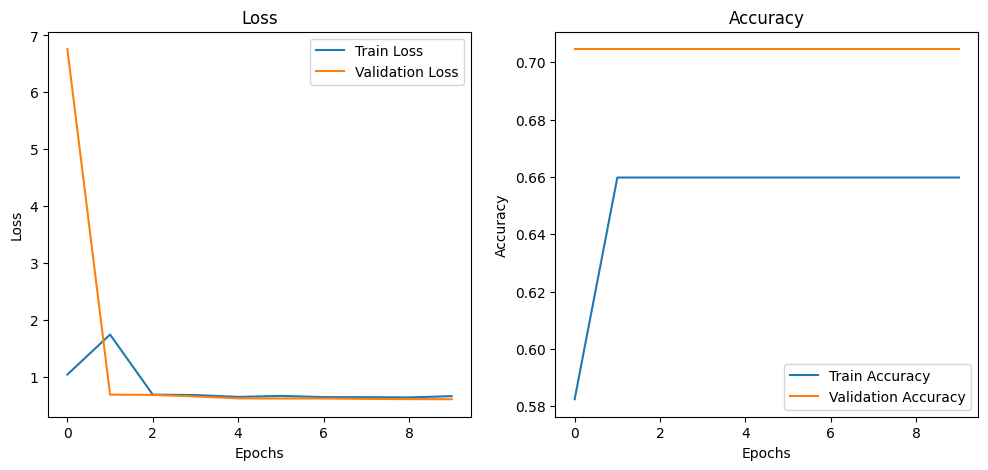

In [6]:
import pickle
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.applications import VGG16
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# 1. 병합된 데이터 로드
with open('/content/drive/MyDrive/TMJ OA/CBCT_MRI_combined_full.pkl', 'rb') as f:
    combined_data = pickle.load(f)

# 데이터 준비 함수: CBCT와 MRI 데이터를 병합
def prepare_merged_data(stage, combined_data):
    cbct_images = combined_data[stage]['CBCT_image']
    mri_images = combined_data[stage]['MRI_image']
    labels = combined_data[stage]['label']

    # 데이터 일관성을 맞추기 위해 공통 길이로 맞춤
    min_samples = min(len(cbct_images), len(mri_images), len(labels))
    merged_images = np.concatenate([cbct_images[:min_samples], mri_images[:min_samples]], axis=-1)

    return merged_images / 255.0, labels[:min_samples]

# Train, Validation, Test 데이터 준비
merged_train, train_labels = prepare_merged_data('train_data', combined_data)
merged_val, val_labels = prepare_merged_data('validation_data', combined_data)
merged_test, test_labels = prepare_merged_data('test_data', combined_data)

print(f"Train Data Shape: {merged_train.shape}, Labels: {train_labels.shape}")
print(f"Validation Data Shape: {merged_val.shape}, Labels: {val_labels.shape}")
print(f"Test Data Shape: {merged_test.shape}, Labels: {test_labels.shape}")

# 2. VGG16 기반 모델 설계
input_shape = merged_train.shape[1:]  # 병합된 데이터의 입력 크기
input_layer = Input(shape=input_shape)

# VGG16 모델 구성
base_model = VGG16(weights=None, include_top=False, input_tensor=input_layer)
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)  # 이진 분류

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# 3. 모델 학습
history = model.fit(
    merged_train, train_labels,
    validation_data=(merged_val, val_labels),
    epochs=10,
    batch_size=32
)

# 4. 성능 평가 함수
def evaluate_model(model, data, labels, stage):
    preds = model.predict(data).flatten()

    # ROC Curve 및 AUC 계산
    fpr, tpr, thresholds = roc_curve(labels, preds)
    model_auc = auc(fpr, tpr)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    # 최종 예측
    final_preds = (preds >= optimal_threshold).astype(int)

    # 성능 지표 계산
    conf_matrix = confusion_matrix(labels, final_preds)
    class_report = classification_report(labels, final_preds)

    print(f"\n{stage} 데이터 평가:")
    print(f"AUC: {model_auc:.4f}")
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)

    # ROC Curve 시각화
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f"AUC = {model_auc:.4f}")
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label="Random Guess")
    plt.title(f"ROC Curve - {stage}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

# 5. Train, Validation, Test 데이터 평가
evaluate_model(model, merged_train, train_labels, "Train")
evaluate_model(model, merged_val, val_labels, "Validation")
evaluate_model(model, merged_test, test_labels, "Test")

# 6. 학습 결과 시각화
plt.figure(figsize=(12, 5))

# Loss 시각화
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy 시각화
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
